In [ ]:
import os
import glob
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd
from sublimpy import utils, extrautils
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')

# Tower Measurements

## Open velocity data and apply monthly planar fits

### SOS

In [ ]:
# Open all files, get variables we want, and concatenate into a single dataset
dir_sos = "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307"
file_list_sos = sorted(glob.glob(os.path.join(dir_sos, "*.nc")))
vars_sos = [
        'dir_3m_c', 'SF_avg_1m_ue', 'SF_avg_2m_ue',
        'w_3m_ue',    'w_10m_ue', 'w_3m_d',     'w_10m_d', 'w_3m_uw',    'w_10m_uw',  
            'w_3m_c',     'w_5m_c',     'w_10m_c',    'w_15m_c',    'w_20m_c',
        'u_3m_ue',    'u_10m_ue', 'u_3m_d',     'u_10m_d', 'u_3m_uw',    'u_10m_uw',  
            'u_3m_c',     'u_5m_c',     'u_10m_c',    'u_15m_c',    'u_20m_c',
        'v_3m_ue',    'v_10m_ue', 'v_3m_d',     'v_10m_d', 'v_3m_uw',    'v_10m_uw',  
            'v_3m_c',     'v_5m_c',     'v_10m_c',    'v_15m_c',    'v_20m_c',
            
    ]

datasets = []
for file in file_list_sos:
    ds = xr.open_dataset(file)
    # this ensures we don't access variables that aren't in this dataset, which would throw an error
    ds_new = ds[set(ds.data_vars).intersection(vars_sos)]
    datasets.append(ds_new)
sos_ds = xr.concat(datasets, dim='time')
sos_ds = utils.fill_missing_timestamps(sos_ds)

In [ ]:
# Iterate over each month, and EC instruments, calculating and applying planar fits to u, v, w data, and combining the monthly datasets into a single dataset
ec_suffixes = [
    '3m_ue',    '10m_ue', '3m_d',     '10m_d', '3m_uw',    '10m_uw',  
    '3m_c',     '5m_c',     '10m_c',    '15m_c',    '20m_c'
]
planar_fitted_ds_ls = []
for month, year in [
    (11, 2022),
    (12, 2022),
    (1, 2023),
    (2, 2023),
    (3, 2023),
    (4, 2023),
    (5, 2023),
    (6, 2023),
]:
    this_ds = sos_ds.sel(time = sos_ds.time.dt.year.isin([year]))
    this_ds = this_ds.sel(time = this_ds.time.dt.month.isin([month]))
    for suffix in ec_suffixes:
        (a,b,c), (tilt, tiltaz), W_f = extrautils.calculate_planar_fit(this_ds[f"u_{suffix}"], this_ds[f"v_{suffix}"], this_ds[f"w_{suffix}"])
        (u_streamwise, v_streamwise, w_streamwise) = extrautils.apply_planar_fit(
            this_ds[f"u_{suffix}"], this_ds[f"v_{suffix}"], this_ds[f"w_{suffix}"],
            a, W_f
        )
        print(f"{month}\t{year}\t{suffix}\t{round(np.rad2deg(tilt), 5)}")
        this_ds[f"u_{suffix}"] = ('time', u_streamwise)
        this_ds[f"v_{suffix}"] = ('time', v_streamwise)
        this_ds[f"w_{suffix}"] = ('time', w_streamwise)
    planar_fitted_ds_ls.append(this_ds)
sos_ds_fitted = xr.concat(planar_fitted_ds_ls, dim='time')

### SPLASH

In [ ]:
# Open all files, get variables we want, and concatenate into a single dataset for both AVP and KPS sites

# SPLASH KETTLE PONDS data
splash_kps_files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledseb.asfs30.level2.0.10min.**.nc")
splash_kps_files = sorted([f for f in splash_kps_files 
    if '202211' in f 
    or '202212' in f 
    or '202301' in f 
    or '202302' in f 
    or '202303' in f 
    or '202304' in f 
    or '202305' in f 
    or '202306' in f 
])
datasets = [xr.open_dataset(file)[['wspd_u_mean', 'wspd_v_mean', 'wspd_w_mean']] for file in splash_kps_files]
splash_kps_ds = xr.concat(datasets, dim='time')
splash_kps_ds = utils.fill_missing_timestamps(splash_kps_ds)

# SPLASH AVERY PICNIC data
splash_avp_files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.**.nc")
splash_avp_files = sorted([f for f in splash_avp_files 
    if '202211' in f 
    or '202212' in f 
    or '202301' in f 
    or '202302' in f 
    or '202303' in f 
    or '202304' in f 
    or '202305' in f 
    or '202306' in f 
])
datasets = [xr.open_dataset(file)[['wspd_u_mean', 'wspd_v_mean', 'wspd_w_mean']] for file in splash_avp_files]
splash_avp_ds = xr.concat(datasets, dim='time')
splash_avp_ds = utils.fill_missing_timestamps(splash_avp_ds)

In [ ]:
# KPS SITE Iterate over each month, calculating and applying planar fits to u, v, w data, and combining the monthly datasets into a single dataset
planar_fitted_ds_ls = []
for month, year in [
    (11, 2022),
    (12, 2022),
    (1, 2023),
    (2, 2023),
    (3, 2023),
    (4, 2023),
    (5, 2023),
    (6, 2023),
]:
    this_ds = splash_kps_ds.sel(time = splash_kps_ds.time.dt.year.isin([year]))
    this_ds = this_ds.sel(time = this_ds.time.dt.month.isin([month]))
    (a,b,c), (tilt, tiltaz), W_f = extrautils.calculate_planar_fit(this_ds[f"wspd_u_mean"], this_ds[f"wspd_v_mean"], this_ds[f"wspd_w_mean"])
    (u_streamwise, v_streamwise, w_streamwise) = extrautils.apply_planar_fit(
        this_ds[f"wspd_u_mean"], this_ds[f"wspd_v_mean"], this_ds[f"wspd_w_mean"],
        a, W_f
    )
    this_ds[f"wspd_u_mean"] = ('time', u_streamwise)
    this_ds[f"wspd_v_mean"] = ('time', v_streamwise)
    this_ds[f"wspd_w_mean"] = ('time', w_streamwise)
    planar_fitted_ds_ls.append(this_ds)
splash_kps_ds_fitted = xr.concat(planar_fitted_ds_ls, dim='time')

In [ ]:
# AVP SITE Iterate over each month, calculating and applying planar fits to u, v, w data, and combining the monthly datasets into a single dataset
planar_fitted_ds_ls = []
for month, year in [
    (11, 2022),
    (12, 2022),
    (1, 2023),
    (2, 2023),
    (3, 2023),
    (4, 2023),
    (5, 2023),
    (6, 2023),
]:
    this_ds = splash_avp_ds.sel(time = splash_avp_ds.time.dt.year.isin([year]))
    this_ds = this_ds.sel(time = this_ds.time.dt.month.isin([month]))
    (a,b,c), (tilt, tiltaz), W_f = extrautils.calculate_planar_fit(this_ds[f"wspd_u_mean"], this_ds[f"wspd_v_mean"], this_ds[f"wspd_w_mean"])
    (u_streamwise, v_streamwise, w_streamwise) = extrautils.apply_planar_fit(
        this_ds[f"wspd_u_mean"], this_ds[f"wspd_v_mean"], this_ds[f"wspd_w_mean"],
        a, W_f
    )
    this_ds[f"wspd_u_mean"] = ('time', u_streamwise)
    this_ds[f"wspd_v_mean"] = ('time', v_streamwise)
    this_ds[f"wspd_w_mean"] = ('time', w_streamwise)
    planar_fitted_ds_ls.append(this_ds)
splash_avp_ds_fitted = xr.concat(planar_fitted_ds_ls, dim='time')

### SAIL

In [ ]:
import act
import os

In [ ]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
ecor_gothic = 'guc30ecorM1.b1'
ecor_kp = 'guc30ecorS3.b1'
met_gothic = 'gucmetM1.b1'
start_date = '20221030'
end_date = '20230701'
output_dir = '/Users/elischwat/Development/data/sublimationofsnow/'

kp_sail_ecor_download_dir = os.path.join(output_dir, ecor_kp)
gothic_sail_ecor_download_dir = os.path.join(output_dir, ecor_gothic)

In [ ]:

act.discovery.download_arm_data(
    username,    token,    'guctsiskyimageM1.a1',    
    '20230418', '20230418',
    output = '/Users/elischwat/Development/data/sublimationofsnow/guctsiskyimageM1.a1/'
)

In [ ]:
act.discovery.download_arm_data(
    username,    token,    ecor_gothic,    
    start_date, end_date,
    output = gothic_sail_ecor_download_dir
)
act.discovery.download_arm_data(
    username,    token,    ecor_kp,    
    start_date, end_date,
    output = kp_sail_ecor_download_dir
)

In [ ]:
sail_gothic_ds = act.io.read_arm_netcdf(
    glob.glob(os.path.join(gothic_sail_ecor_download_dir, '*.cdf'))
)[['mean_u', 'mean_v', 'mean_w']]

sail_kps_ds = act.io.read_arm_netcdf(
    glob.glob(os.path.join(kp_sail_ecor_download_dir, '*.cdf'))
)[['mean_u', 'mean_v', 'mean_w']]

In [ ]:
# GOTHIC SITE Iterate over each month, calculating and applying planar fits to u, v, w data, and combining the monthly datasets into a single dataset
planar_fitted_ds_ls = []
for month, year in [
    (11, 2022),
    (12, 2022),
    (1, 2023),
    (2, 2023),
    (3, 2023),
    (4, 2023),
    (5, 2023),
    (6, 2023),
]:
    this_ds = sail_gothic_ds.sel(time = sail_gothic_ds.time.dt.year.isin([year]))
    this_ds = this_ds.sel(time = this_ds.time.dt.month.isin([month]))
    (a,b,c), (tilt, tiltaz), W_f = extrautils.calculate_planar_fit(this_ds[f"mean_u"], this_ds[f"mean_v"], this_ds[f"mean_w"])
    (u_streamwise, v_streamwise, w_streamwise) = extrautils.apply_planar_fit(
        this_ds[f"mean_u"], this_ds[f"mean_v"], this_ds[f"mean_w"],
        a, W_f
    )
    this_ds[f"mean_u"] = ('time', u_streamwise)
    this_ds[f"mean_v"] = ('time', v_streamwise)
    this_ds[f"mean_w"] = ('time', w_streamwise)
    planar_fitted_ds_ls.append(this_ds)
sail_gothic_ds_fitted = xr.concat(planar_fitted_ds_ls, dim='time')

In [ ]:
# GOTHIC SITE Iterate over each month, calculating and applying planar fits to u, v, w data, and combining the monthly datasets into a single dataset
planar_fitted_ds_ls = []
for month, year in [
    (11, 2022),
    (12, 2022),
    (1, 2023),
    (2, 2023),
    (3, 2023),
    (4, 2023),
    (5, 2023),
    (6, 2023),
]:
    this_ds = sail_kps_ds.sel(time = sail_kps_ds.time.dt.year.isin([year]))
    this_ds = this_ds.sel(time = this_ds.time.dt.month.isin([month]))
    (a,b,c), (tilt, tiltaz), W_f = extrautils.calculate_planar_fit(this_ds[f"mean_u"], this_ds[f"mean_v"], this_ds[f"mean_w"])
    (u_streamwise, v_streamwise, w_streamwise) = extrautils.apply_planar_fit(
        this_ds[f"mean_u"], this_ds[f"mean_v"], this_ds[f"mean_w"],
        a, W_f
    )
    this_ds[f"mean_u"] = ('time', u_streamwise)
    this_ds[f"mean_v"] = ('time', v_streamwise)
    this_ds[f"mean_w"] = ('time', w_streamwise)
    planar_fitted_ds_ls.append(this_ds)
sail_kps_ds_fitted = xr.concat(planar_fitted_ds_ls, dim='time')

### Conform all data to similar format

In [ ]:
sos_df = sos_ds_fitted.to_dataframe()
sos_df_local = utils.modify_df_timezone(sos_df.reset_index(), 'UTC', 'US/Mountain')
sos_df_local = sos_df_local.set_index('time').resample('30min').mean().reset_index()

In [ ]:
splash_avp_df = splash_avp_ds_fitted.to_dataframe()
splash_avp_df_local = utils.modify_df_timezone(splash_avp_df.reset_index(), 'UTC', 'US/Mountain')
splash_avp_df_local = splash_avp_df_local.set_index('time').resample('30min').mean().reset_index()

splash_kps_df = splash_kps_ds_fitted.to_dataframe()
splash_kps_df_local = utils.modify_df_timezone(splash_kps_df.reset_index(), 'UTC', 'US/Mountain')
splash_kps_df_local = splash_kps_df_local.set_index('time').resample('30min').mean().reset_index()

In [ ]:
sail_gothic_df = sail_gothic_ds_fitted.to_dataframe()
sail_gothic_df_local = utils.modify_df_timezone(sail_gothic_df.reset_index(), 'UTC', 'US/Mountain')

sail_kps_df = sail_kps_ds_fitted.to_dataframe()
sail_kps_df_local = utils.modify_df_timezone(sail_kps_df.reset_index(), 'UTC', 'US/Mountain')

In [ ]:
w_combo_df = sos_df_local[['time', 'w_3m_c', 'w_20m_c']].rename(
    columns={
        'w_3m_c': 'w KPS SOS_3m',
        'w_20m_c': 'w KPS SOS_20m',
    }
).merge(
    splash_avp_df_local[['time', 'wspd_w_mean']].rename(columns={'wspd_w_mean': 'w AVP SPLASH'}),
    on='time'
).merge(
    splash_kps_df_local[['time', 'wspd_w_mean']].rename(columns={'wspd_w_mean': 'w KPS SPLASH'}),
    on='time'
).merge(
    sail_gothic_df_local[['time', 'mean_w']].rename(columns={'mean_w': 'w GOT SAIL'}),
    on='time'
).merge(
    sail_kps_df_local[['time', 'mean_w']].rename(columns={'mean_w': 'w KPS SAIL'}),
    on='time'
)

In [ ]:
w_combo_df_tidy = w_combo_df.set_index('time').melt(ignore_index=False)
w_combo_df_tidy['site'] = w_combo_df_tidy.variable.apply(lambda s: s.split(' ')[-2])
w_combo_df_tidy['campaign'] = w_combo_df_tidy.variable.apply(lambda s: s.split(' ')[-1])
w_combo_df_tidy = w_combo_df_tidy.reset_index()
w_combo_df_tidy.head()

## PLOT: Vertical velocities

In [ ]:
rule = alt.Chart().transform_calculate(y='0').mark_rule(strokeWidth=2).encode(y='y:Q')

### Seasonal analysis - upvalley vs downvalley winds

In [ ]:
upvalley_wind_times = sos_df_local.query("dir_3m_c < 152").query("dir_3m_c > 92").time.values
downvalley_wind_times = sos_df_local.query("dir_3m_c < 342").query("dir_3m_c > 292").time.values

is_no_bs = (sos_df_local.set_index('time')[['SF_avg_1m_ue', 'SF_avg_2m_ue']] > 0).sum(axis=1)
no_bs_times = is_no_bs[is_no_bs == 0].index.values

In [ ]:
(alt.Chart(
    w_combo_df_tidy[w_combo_df_tidy.time > '20221130'][w_combo_df_tidy.time < '20230505'][
        w_combo_df_tidy.time.isin(set(upvalley_wind_times).intersection(set(no_bs_times)))
    ]
).transform_filter(
    "datum.variable != 'w KPS SPLASH'"
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(value):Q'),
    alt.Color('site:N'),
    alt.StrokeDash('campaign'),
).properties(width=150, height = 150) | alt.Chart(
    w_combo_df_tidy[w_combo_df_tidy.time > '20221130'][w_combo_df_tidy.time < '20230505'][
        w_combo_df_tidy.time.isin(set(downvalley_wind_times).intersection(set(no_bs_times)))
    ]
).transform_filter(
    "datum.variable != 'w KPS SPLASH'"
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(value):Q'),
    alt.Color('site:N'),
    alt.StrokeDash('campaign'),
).properties(width=150, height = 150)).resolve_scale(y='shared')

### Case studies

Make sure we can replicate the plots from Chapter 1

In [ ]:
DATE_START = '20230505'
DATE_END = '20230506'
rule + alt.Chart(
    sos_df_local[sos_df_local.time > DATE_START][sos_df_local.time < DATE_END].set_index('time')[['w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c']].resample('30min').mean().reset_index()
).mark_line().transform_fold(
    ['w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c'],
    as_=['height', 'value']
).encode(
    alt.X('time:T'). axis().title(None),
    alt.Y('value:Q').title(['Vertical wind speed (m/s)']),
    alt.Color('height:O').scale(scheme='turbo', domain=[
        'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c'
    ])
).properties(width=300, height = 125)

In [ ]:
DATE_START = '20230505'
DATE_END = '20230506'
rule + alt.Chart(
    w_combo_df_tidy[w_combo_df_tidy.time > DATE_START][w_combo_df_tidy.time < DATE_END]
).transform_filter(
    "datum.variable != 'w KPS SPLASH'"
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-2,2],
    groupby = ['variable']
).mark_line(color='#beddf4', opacity=0.75).encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('site:N'),
    alt.StrokeDash('campaign'),
    detail = 'variable'
).properties(height = 200)

In [ ]:
DATE_START = '20230415'
DATE_END = '20230416'
rule + alt.Chart(
    w_combo_df_tidy[w_combo_df_tidy.time > DATE_START][w_combo_df_tidy.time < DATE_END]
).transform_filter(
    "datum.variable != 'w KPS SPLASH'"
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-2,2],
    groupby = ['variable']
).mark_line(color='#beddf4', opacity=0.75).encode(
    alt.X('time:T'),
    alt.Y('rolling_avg:Q'),
    alt.Color('site:N'),
    alt.StrokeDash('campaign'),
    detail = 'variable'
).properties(height = 200)

In [ ]:
# sos_ds['w_10m_c'].loc['20230415'].plot()
sos_ds['w_10m_c'].loc['20230418 1200': '20230418 1800'].plot()

In [ ]:
DATE_START = '20230417'
DATE_END = '20230418'
rule + alt.Chart(
    w_combo_df_tidy[w_combo_df_tidy.time > DATE_START][w_combo_df_tidy.time < DATE_END]
).transform_filter(
    "datum.variable != 'w KPS SPLASH'"
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-2,2],
    groupby = ['variable']
).mark_line(color='#beddf4', opacity=0.75).encode(
    alt.X('time:T'),
    alt.Y('rolling_avg:Q'),
    alt.Color('site:N'),
    alt.StrokeDash('campaign'),
    detail = 'variable'
).properties(height = 200)

# Doppler Lidar Measurements

In [ ]:
ls /Users/elischwat/Development/data/sublimationofsnow/| grep gucdl

## Vertical Velocity Mean

In [ ]:
dl_w_stats_files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwstats4newsM1.c1/*.nc")

In [ ]:
def get_dataframe_from_netcdf_files(files, start_date, end_date):
    wstats_df = xr.open_mfdataset(files).to_dataframe().reset_index()
    wstats_df = utils.modify_df_timezone(wstats_df, 'UTC', 'US/Mountain')
    wstats_df = wstats_df[(wstats_df.time > start_date) & (wstats_df.time < end_date)]
    wstats_df['time_low'] = wstats_df['time'] - dt.timedelta(minutes=5)
    wstats_df['time_high'] = wstats_df['time'] + dt.timedelta(minutes=5)
    wstats_df['height_low'] = wstats_df['height'] - 15
    wstats_df['height_high'] = wstats_df['height'] + 15
    return wstats_df

def get_mean_w_chart(df, w_min, w_max):
    mean_mean_w_rule_chart = alt.Chart(
        df.set_index('time').query("height < 2000").reset_index()
    ).mark_rule().encode(
        alt.X('mean(w):Q')
    ).properties(
        width=200, height = 200,
    ).properties(title=f"Mean: {round(df.set_index('time').query("height < 2000").w.mean(), 5)}"[:13])

    mean_w_distribution_chart = alt.Chart(
        df.set_index('time').query("height < 2000").reset_index()
    ).mark_bar().encode(
        alt.X('w:Q').title(["w", "(m/s)"]).bin(step=0.25).axis(values=[w_min,0,w_max]).scale(domain=[w_min,w_max], clamp=True),
        alt.Y('count():Q')
    ).properties(
        width=200, height = 200,
    )

    mean_w_timeseries_chart = alt.Chart(
        df.set_index('time').query("height < 2000").reset_index()
    ).mark_rect().encode(
        alt.X('time_low:T').title('time'),
        alt.X2('time_high:T'),
        alt.Y('height_low:Q').title('Height (m)'),
        alt.Y2('height_high:Q'),
        alt.Color('w:Q').title(["w", "(m/s)"]).scale(scheme='purpleorange', domain=[w_min,w_max]),
    ).properties(
        width=500, height = 200,
        title = 'Vertical velocity from Doppler Lidar at Gothic'
    )

    return (mean_w_distribution_chart + mean_mean_w_rule_chart) | mean_w_timeseries_chart

In [ ]:
casestudy1_dl_w_stats_files = [f for f in dl_w_stats_files if '20230505' in f or '20230506' in f]
casestudy1_dl_w_stats_df = get_dataframe_from_netcdf_files(casestudy1_dl_w_stats_files, '20230505', '20230506')
get_mean_w_chart(casestudy1_dl_w_stats_df, -1.5, 1.5)

In [ ]:
casestudy2_dl_w_stats_files = [f for f in dl_w_stats_files if '20230415' in f or '20230416' in f]
casestudy2_dl_w_stats_df = get_dataframe_from_netcdf_files(casestudy2_dl_w_stats_files, '20230415', '20230416')
get_mean_w_chart(casestudy2_dl_w_stats_df, -1.5, 1.5)

In [ ]:
casestudy2point5_dl_w_stats_files = [f for f in dl_w_stats_files if '20230418' in f or '20230419' in f]
casestudy2point5_dl_w_stats_df = get_dataframe_from_netcdf_files(casestudy2point5_dl_w_stats_files, '20230418', '20230419')
get_mean_w_chart(casestudy2point5_dl_w_stats_df, -1.5, 1.5)

In [ ]:
casestudy3_dl_w_stats_files = [f for f in dl_w_stats_files if '20230417' in f or '20230418' in f]
casestudy3_dl_w_stats_df = get_dataframe_from_netcdf_files(casestudy3_dl_w_stats_files, '20230417', '20230418')
get_mean_w_chart(casestudy3_dl_w_stats_df, -1.5, 1.5)

## Vertical Velocity Variance

In [ ]:
def get_var_w_chart(df):
    return alt.Chart(
        df.set_index('time').query("height < 2000").query("height >= 20").reset_index()
    ).mark_rect().encode(
        alt.X('time_low:T').title('time'),
        alt.X2('time_high:T'),
        alt.Y('height_low:Q').title('Height (m)').scale(domain = [20, 2000]),
        alt.Y2('height_high:Q'),
        alt.Color('w_variance:Q').title(["w'w'", "(m² s⁻²)"]).scale(scheme='turbo'),
        tooltip='w_variance'
    ).properties(
        width=500, height = 200,
        title = 'Vertical velocity variance from Doppler Lidar at Gothic'
    )

In [ ]:
(get_var_w_chart(casestudy1_dl_w_stats_df) &\
get_var_w_chart(casestudy2_dl_w_stats_df) &\
get_var_w_chart(casestudy3_dl_w_stats_df)).resolve_scale(color='independent')

In [ ]:
(get_var_w_chart(casestudy2_dl_w_stats_df) &\
get_var_w_chart(casestudy2point5_dl_w_stats_df)).display(renderer='svg')

## Horizontal wind - profiles

In [3]:
USERNAME = os.getenv("ARM_USERNAME")
TOKEN = os.getenv("ARM_TOKEN")
SAIL_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DATA_STREAM_FILEEXT = '.nc'
startdate = "2023-02-01"
enddate = "2023-06-01"
output_dir = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", SAIL_DATA_STREAM)


In [ ]:
act.discovery.download_arm_data(USERNAME, TOKEN, SAIL_DATA_STREAM, startdate, enddate, output=output_dir)

In [4]:
dl_w_prof_files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/*.nc")

In [5]:
dl_w_prof_files

['/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230217.001420.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230315.001421.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230409.001421.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230615.001420.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230301.001421.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230206.000040.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230210.000039.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/gucdlprofwind4newsM1.c1.20230428.001421.nc',
 '/Users/elischw

In [6]:
import act

In [7]:
prof_ds = act.io.read_arm_netcdf(dl_w_prof_files)
prof_ds.time.min(), prof_ds.time.max()

(<xarray.DataArray 'time' ()> Size: 8B
 array('2023-02-01T00:00:39.881244000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-06-15T23:59:20.789108000', dtype='datetime64[ns]'))

In [8]:
prof_df = prof_ds.to_dataframe()
prof_df = utils.modify_df_timezone(prof_df.reset_index(), 'UTC', 'US/Mountain').set_index('time')

In [9]:
hourly_mean_prof_df = prof_df.query("height > 950").query("height < 1100")[['wind_speed', 'wind_direction']].reset_index().set_index('time').groupby(pd.Grouper(freq='60min')).mean()

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

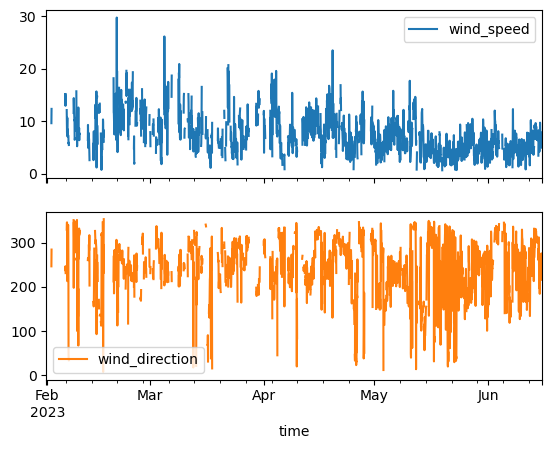

In [10]:
hourly_mean_prof_df[['wind_speed', 'wind_direction']].plot(subplots=True)

In [11]:
synoptic_winds_30min = hourly_mean_prof_df.resample('30min').mean().ffill()
along_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 299)
    & (synoptic_winds_30min.wind_direction < 345 )
].index.values
cross_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 202)
    & (synoptic_winds_30min.wind_direction < 248 )
].index.values
len(cross_valley_wind_times), len(along_valley_wind_times)

(1648, 1040)

In [13]:
synoptic_winds_30min

,wind_speed,wind_direction
time,,
2023-01-31 17:00:00,NaN,NaN
2023-01-31 17:30:00,NaN,NaN
2023-01-31 18:00:00,NaN,NaN
2023-01-31 18:30:00,NaN,NaN
2023-01-31 19:00:00,NaN,NaN
...,...,...
2023-06-15 15:00:00,5.590463,226.380692
2023-06-15 15:30:00,5.590463,226.380692
2023-06-15 16:00:00,5.517020,250.700287


# Surface Measurements

In [56]:
sos_tidy_fn = f"../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000.parquet"
tidy_df = pd.read_parquet(sos_tidy_fn)
# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
tidy_df = tidy_df[tidy_df.time > '20221107']

In [61]:
src = tidy_df[tidy_df.variable.isin(['tke_3m_c', 'spd_3m_c'])].pivot(index='time', columns='variable', values='value')
src = pd.concat([
        src.loc['20230415'].reset_index(),
        src.loc['20230418'].reset_index()
    ])
src['sqrt(tke)'] = src['tke_3m_c']**0.5

windspeed_casestudy_chart = alt.Chart(
    src
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('spd_3m_c:Q'),
    alt.Color('date(time):N')
).properties(width=200, height = 200)

regime_casestudy_chart = (alt.Chart(
    src
).mark_point(size=20, color='orange').encode(
    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),
    alt.Y('sqrt(tke)'),
    alt.Color('date(time):N')
).properties(width=200, height = 200))

windspeed_casestudy_chart | regime_casestudy_chart

alt.HConcatChart(...)

In [63]:
src = tidy_df[tidy_df.variable.isin(['tke_3m_c', 'spd_3m_c', 'w_h2o__3m_c', 'w_tc__3m_c'])].pivot(index='time', columns='variable', values='value')
src = pd.concat([
        src[src.index.isin(cross_valley_wind_times)].assign(synoptic_wind = 'cross valley'),
        src[src.index.isin(along_valley_wind_times)].assign(synoptic_wind = 'along valley')
    ])
src['sqrt(tke)'] = src['tke_3m_c']**0.5
turbulence_regime_scatter_chart = alt.Chart(
    src
).mark_circle(size=5, color='orange').encode(
    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),
    alt.Y('sqrt(tke)'),
    alt.Color('synoptic_wind:N')
).properties(width=200, height = 200)
turbulence_regime_scatter_chart

alt.Chart(...)

In [64]:
src['spd bin'] = pd.cut(
    src['spd_3m_c'], 
    np.arange(0,11), 
    # labels = [f"{lo}-{hi}" for lo, hi in zip(np.arange(0,11), np.arange(1,11))]
    labels = [(lo + hi)/2 for lo, hi in zip(np.arange(0,11), np.arange(1,11))]
)


In [68]:
turbulence_regime_box_chart = alt.Chart(
    src
).mark_boxplot(outliers=False, opacity=0.5, box={'stroke': 'black'}).encode(
    alt.X('spd bin:Q').title('3m wind speed (m/s)'),
    alt.Y('sqrt(tke):Q'),
    alt.Color('synoptic_wind:N'),
).properties(width=200, height = 200)

In [72]:
(
    windspeed_casestudy_chart 
    | (
        regime_casestudy_chart 
        | (turbulence_regime_scatter_chart + turbulence_regime_box_chart)
    ).resolve_scale(y='shared', x='shared', color='independent')
).resolve_scale(color='independent')

alt.HConcatChart(...)

In [52]:
(alt.Chart(
    src
).mark_boxplot(outliers=False, opacity=0.5, box={'stroke': 'black'}).encode(
    alt.X('spd bin:Q').title('3m wind speed (m/s)'),
    alt.Y('w_h2o__3m_c:Q').title('TKE at 3m (m²/s²)'),
    alt.Color('synoptic_wind:N'),
).properties(width=200, height = 200) | alt.Chart(
    src
).mark_boxplot(outliers=False, opacity=0.5, box={'stroke': 'black'}).encode(
    alt.X('spd bin:Q').title('3m wind speed (m/s)'),
    alt.Y('w_h2o__20m_c:Q').title('TKE at 3m (m²/s²)'),
    alt.Color('synoptic_wind:N'),
).properties(width=200, height = 200)).resolve_scale(x='shared', y='shared')

alt.HConcatChart(...)

In [53]:
(alt.Chart(
    src
).mark_boxplot(outliers=False, opacity=0.5, box={'stroke': 'black'}).encode(
    alt.X('spd bin:Q').title('3m wind speed (m/s)'),
    alt.Y('w_tc__3m_c:Q').title('TKE at 3m (m²/s²)'),
    alt.Color('synoptic_wind:N'),
).properties(width=200, height = 200) | alt.Chart(
    src
).mark_boxplot(outliers=False, opacity=0.5, box={'stroke': 'black'}).encode(
    alt.X('spd bin:Q').title('3m wind speed (m/s)'),
    alt.Y('w_tc__20m_c:Q').title('TKE at 3m (m²/s²)'),
    alt.Color('synoptic_wind:N'),
).properties(width=200, height = 200)).resolve_scale(x='shared', y='shared')

alt.HConcatChart(...)

In [54]:
turbulence_regime_box_chart

alt.Chart(...)

In [55]:
src['sqrt(tke)'] = src['tke_3m_c']**(0.5)
turbulence_regime_box_chart = alt.Chart(
    src
).mark_boxplot(opacity=0.5, box={'stroke': 'black'}, outliers=False).encode(
    alt.X('spd bin:Q').title('3m wind speed (m/s)'),
    alt.Y('sqrt(tke):Q').title('TKE at 3m (m²/s²)'),
    alt.Color('synoptic_wind:N'),
).properties(width=200, height = 200)

turbulence_regime_chart = (turbulence_regime_scatter_chart + turbulence_regime_box_chart).resolve_scale(
    x='shared'
)
turbulence_regime_chart

alt.LayerChart(...)

In [26]:
synoptic_winds_pdf_chart =alt.Chart(
    pd.concat([
        synoptic_winds_30min[synoptic_winds_30min.index.isin(cross_valley_wind_times)].assign(synoptic_wind = 'cross valley'),
        synoptic_winds_30min[synoptic_winds_30min.index.isin(along_valley_wind_times)].assign(synoptic_wind = 'along valley')
    ])
).transform_density(
    'wind_speed',
    as_ = ['wind speed', 'density'],
    groupby=['synoptic_wind']
).mark_line().encode(
    alt.X('wind speed:Q').title('1000m wind speed (m/s)'),
    alt.Y('density:Q').title('PDF (kernel density estimate)'),
    alt.Color('synoptic_wind:N').title(['Synoptic wind', 'direction'])
).properties(width = 200, height = 200)
synoptic_winds_pdf_chart

alt.Chart(...)

In [27]:
turbulence_regime_chart | synoptic_winds_pdf_chart

alt.HConcatChart(...)

In [28]:
src = pd.concat([
    tidy_df.query("measurement == 'temperature'"),
    tidy_df.query("variable == 'Tsurf_c'"),
])

src = src[src.time <= '20230411 1600'][src.time >= '20230411 0900']
alt.Chart(src).mark_circle().encode(
    alt.X('value:Q').title('temp. (˚C)').axis(values=[0,2,4,6,8,10]),
    alt.Y('height:Q').title('height (m)'),
    alt.Facet('time:T', columns=5).header(format='April %d %H:%M')
).properties(width=100, height=100).display(renderer='svg')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_83627/1854167277.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = src[src.time <= '20230411 1600'][src.time >= '20230411 0900']


alt.Chart(...)

In [29]:
src = pd.concat([
    tidy_df.query("measurement == 'temperature'"),
    tidy_df.query("variable == 'Tsurf_c'"),
])

src = src[src.time <= '20230211 1600'][src.time >= '20230211 0900']
alt.Chart(src).mark_circle().encode(
    alt.X('value:Q').title('temp. (˚C)'),
    alt.Y('height:Q').title('height (m)'),
    alt.Facet('time:T', columns=5).header(format='February %d %H:%M')
).properties(width=100, height=100).display(renderer='svg')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_83627/3199548181.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = src[src.time <= '20230211 1600'][src.time >= '20230211 0900']


alt.Chart(...)

# Local Scaling - does MOST work ?

Calculate dimensionless wind gradient (stability correction) and the stability function (z/L)

In [73]:
# src = tidy_df [tidy_df.time > '20230415'][tidy_df.time < '20230418']
HEIGHT = 3
src = tidy_df.copy()
src = src[src.variable.isin([
    'u*_3m_c', 'spd_3m_c', 'L_3m_c', 'Tvirtual_3m_c', 'w_tc__3m_c', 'wind_gradient_3m_c', 'temp_gradient_3m_c'
])]
src = src.pivot_table(values='value', columns='variable', index='time')
src['L_3m_c'] = - (src['u*_3m_c']**3)*(src['Tvirtual_3m_c']+273.5) / (0.4 * 9.81 * src['w_tc__3m_c'])
src['z_over_l'] = HEIGHT / src['L_3m_c']
src['stability_correction'] = 0.4*HEIGHT*src['wind_gradient_3m_c']/src['u*_3m_c']

src_along_valley_times = src[src.index.isin(along_valley_wind_times)]
src_cross_valley_times = src[src.index.isin(cross_valley_wind_times)]

Create a fit line for a couple different stability corrections

In [74]:
def holtslag_and_debruin(zeta):
    return (
        1 + 0.7*zeta + 0.75*zeta*(6 - 0.35*zeta)*np.exp(-0.35*zeta)
    )
def lettau(zeta):
    return (1 + 4.5*zeta)**0.75
fits_domain_stable = pd.Series(np.linspace(0,2))
fits_domain_unstable = pd.Series(np.linspace(-2,0))
fits_df = pd.concat([
    pd.DataFrame({
        'z_over_l': fits_domain_stable,
        'stability_correction': fits_domain_stable.apply(lettau),
    }),
    pd.DataFrame({
        'z_over_l': fits_domain_unstable,
        'stability_correction': (1 - 15 * fits_domain_unstable)**(-0.25)
    })
])

In [75]:
alt.Chart(
    src
).mark_circle(size=2).encode(
    alt.X('z_over_l').scale(domain=[-2, 2], clamp=True),
    alt.Y('stability_correction').scale(domain=[0, 6], clamp=True)
).properties(title='All data') +\
    alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q'),
    alt.Y('stability_correction:Q')
).properties(width=250, height = 250)

alt.LayerChart(...)

In [77]:
all_data_chart = (alt.Chart(
    src.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10")
).mark_boxplot(outliers=False).encode(
    alt.X('z_over_l:Q').bin(step=0.2),
    alt.Y('stability_correction:Q')
) +\
    alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q'),
    alt.Y('stability_correction:Q')
)).properties(title='All Data', width=250, height = 250)

along_valley_chart = (alt.Chart(
    src_along_valley_times.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10")
).mark_boxplot(outliers=False).encode(
    alt.X('z_over_l:Q').bin(step=0.2),
    alt.Y('stability_correction:Q')
) +\
    alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q'),
    alt.Y('stability_correction:Q')
)).properties(title='Along-valley synoptic winds', width=250, height = 250)
cross_valley_chart = (alt.Chart(
    src_cross_valley_times.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10")
).mark_boxplot(outliers=False).encode(
    alt.X('z_over_l:Q').bin(step=0.2),
    alt.Y('stability_correction:Q')
) +\
    alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q'),
    alt.Y('stability_correction:Q')
)).properties(title='Cross-valley synoptic winds', width=250, height = 250)
all_data_chart | along_valley_chart | cross_valley_chart

alt.HConcatChart(...)

In [90]:
all_data_chart = (alt.Chart(
    src.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10")
).mark_circle().encode(
    alt.X('z_over_l:Q').bin(step=0.2),
    alt.Y('median(stability_correction):Q')
) +\
    alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q'),
    alt.Y('stability_correction:Q')
)).properties(title='All Data', width=250, height = 250)

along_valley_chart = (alt.Chart(
    src_along_valley_times.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10")
).mark_point().encode(
    alt.X('z_over_l:Q').bin(step=0.2),
    alt.Y('median(stability_correction):Q')
) +\
    alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q'),
    alt.Y('stability_correction:Q')
)).properties(title='Along-valley synoptic winds', width=250, height = 250)
cross_valley_chart = (alt.Chart(
    src_cross_valley_times.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10")
).mark_point(shape='square').encode(
    alt.X('z_over_l:Q').bin(step=0.2),
    alt.Y('median(stability_correction):Q')
) +\
    alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q'),
    alt.Y('stability_correction:Q')
)).properties(title='Cross-valley synoptic winds', width=250, height = 250)
all_data_chart | along_valley_chart | cross_valley_chart

alt.HConcatChart(...)

In [116]:
combo_df = pd.concat([
    # src.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10").assign(category = 'all data'),
    src_along_valley_times.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10").assign(category = 'along valley'),
    src_cross_valley_times.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10").assign(category = 'cross valley'),
])

(
    # case study plot
    ####################################
    alt.Chart(
        pd.concat([
            src.loc['20230415'],
            src.loc['20230418']
        ]).reset_index().query("z_over_l < 2")
    ).mark_point(opacity=.5).encode(
        alt.X('z_over_l').scale(domain=[-2, 2], clamp=True),
        alt.Y('stability_correction').scale(domain=[0, 6], clamp=True),
        alt.Color('date(time):N')
    ) +\
        alt.Chart(fits_df).mark_line(color='red').encode(
        alt.X('z_over_l:Q'),
        alt.Y('stability_correction:Q')
    ).properties(title='Two days in April', width=150, height = 250)
    
    # summary study plot
    ####################################
    |
    (alt.Chart(
        combo_df
    ).mark_point().encode(
        alt.X('z_over_l:Q').bin(step=0.2).axis(values=[-2,-1,0,1,2], format='.0f', tickCount=5),
        alt.Y('median(stability_correction):Q'),
        alt.Color('category:N'),
    ) + alt.Chart(fits_df).mark_line(color='red').encode(
        alt.X('z_over_l:Q'),
        alt.Y('stability_correction:Q')
    )).properties(title='All Data', width=150, height = 250) 

).resolve_scale(color='independent').display(renderer='svg')

alt.HConcatChart(...)